#create Tiles


In [ ]:
!cp /content/drive/MyDrive/zistagene/303_5.tif /content/

In [ ]:
!ls

data  drive  sample_data  Whole-Image-Slides-Unsupervised-Categorization


In [ ]:
img = tiffile.imread("/content/drive/MyDrive/zistagene/303_5.tif")

In [ ]:
img.shape

(29487, 45697, 3)

In [ ]:
mkdir newtiles

In [ ]:
y = 2000
i = 0
while y < img.shape[1]-256:
    x = 2000
    while x < img.shape[0]-256:
        tile = img[x:x+256,y:y+256]
        tiffile.imsave("newtiles/"+str(i)+".tif", tile)
        i+=1
        x+=256
    y+=256


In [ ]:
!zip -r tiles.zip tiles 

	zip warning: name not matched: tiles

zip error: Nothing to do! (try: zip -r tiles.zip . -i tiles)


In [ ]:
!zip -r /content/drive/MyDrive/zistagene newtiles

	zip warning: name not matched: newtiles

zip error: Nothing to do! (try: zip -r /content/drive/MyDrive/zistagene . -i newtiles)


#Load Tiles

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/tissuetiles.zip -d /content/ 

Streaming output truncated to the last 5000 lines.
  inflating: /content/newtiles/4680.tif  
  inflating: /content/newtiles/2045.tif  
  inflating: /content/newtiles/7614.tif  
  inflating: /content/newtiles/3928.tif  
  inflating: /content/newtiles/9860.tif  
  inflating: /content/newtiles/9455.tif  
  inflating: /content/newtiles/11184.tif  
  inflating: /content/newtiles/10309.tif  
  inflating: /content/newtiles/6674.tif  
  inflating: /content/newtiles/3551.tif  
  inflating: /content/newtiles/17940.tif  
  inflating: /content/newtiles/5889.tif  
  inflating: /content/newtiles/2171.tif  
  inflating: /content/newtiles/3151.tif  
  inflating: /content/newtiles/1551.tif  
  inflating: /content/newtiles/884.tif  
  inflating: /content/newtiles/12095.tif  
  inflating: /content/newtiles/2613.tif  
  inflating: /content/newtiles/14352.tif  
  inflating: /content/newtiles/6881.tif  
  inflating: /content/newtiles/8318.tif  
  inflating: /content/newtiles/5.tif  
  inflating: /content/ne

#Import Libraries

In [ ]:
!pip install tiffile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
# Clustering
from sklearn.mixture import GaussianMixture         # 3) Gaussian Mixture Models
from sklearn import metrics
import tiffile
from skimage.color import rgb2hed
from sklearn.preprocessing import StandardScaler
# Evaluation
from sklearn import metrics
from tqdm import tqdm
from skimage.color import rgb2hed


In [ ]:
def calculateMeanHE(image):
    hedImage = rgb2hed(image) # hed is short for Hematox, Eosin, DAB
    hemaValues = hedImage[:, :, 0]
    eosValues = hedImage[:, :, 1]
    return [hemaValues.mean(), eosValues.mean()]

def calculateMeanRGB(image):
    pixels = image.load()
    width, height = image.size 
    num_pixels = width * height
    r_mean = g_mean = b_mean = 0 
    for i in range(width):
        for j in range(height): 
            r,g,b=pixels[i,j] 
            r_mean += r
            g_mean += g
            b_mean += b
    return [r_mean/num_pixels , g_mean/num_pixels , b_mean/num_pixels]


#GMM With Manual Features


In [ ]:
directory = "/content/newtiles/"
mean_List = []
image_names = []
for filename in tqdm(os.listdir(directory)):
    if (filename.endswith('tif') or filename.endswith('jpeg') or filename.endswith('jpg') or filename.endswith('png')):
        image = Image.open(os.path.join(directory, filename))
        image_names.append(filename)
        mean_List.append(calculateMeanHE(image) + calculateMeanRGB(image))

meanMatrix = np.asarray(mean_List)



100%|██████████| 18190/18190 [08:32<00:00, 35.47it/s]


Scaling the data
(18190, 5)
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True
Finished clustering


In [ ]:
print("Scaling the data")
# Standardize the dataset by removing the mean and scaling to unit variance z =(x-u)/s
scaler = StandardScaler()
scaledData = scaler.fit_transform(meanMatrix)
print(scaledData.shape)
gmm = GaussianMixture(n_components = 6, covariance_type='full', verbose=1).fit(scaledData)

gmmlabels_ = gmm.predict(scaledData)

print("Finished clustering")

Scaling the data
(18190, 5)
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Finished clustering


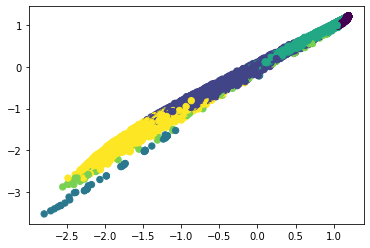

In [ ]:
labels = gmm.predict(scaledData)
plt.scatter(scaledData[:, 3], scaledData[:, 4], c=labels, s=40, cmap='viridis');

In [ ]:
from random import sample
def show_sample(label, data):
    samples = []
    for i in range(len(data)):
        if labels[i] == label:
            samples.append(image_names[i])
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))
    i = 0
    for name in sample(samples, 12):
        imggg = Image.open(os.path.join(directory, name))
        axes[i//4,i%4].imshow(imggg)
        i+=1

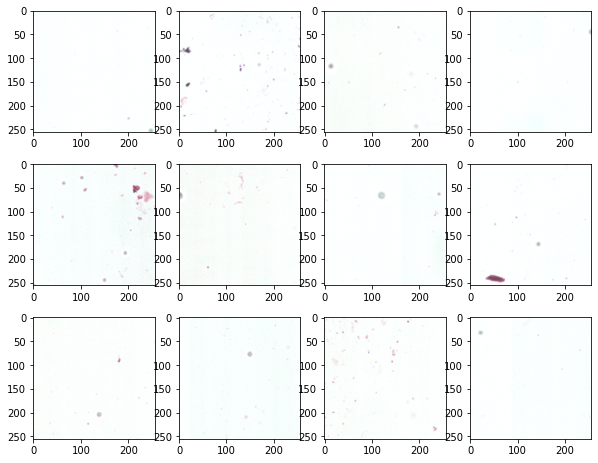

In [ ]:
show_sample(0, scaledData)

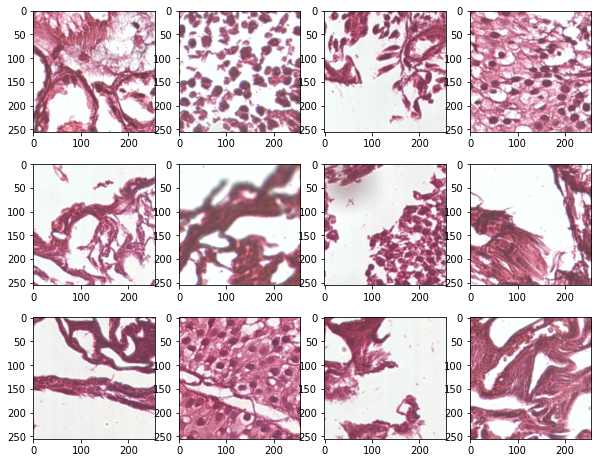

In [ ]:
show_sample(1, scaledData)

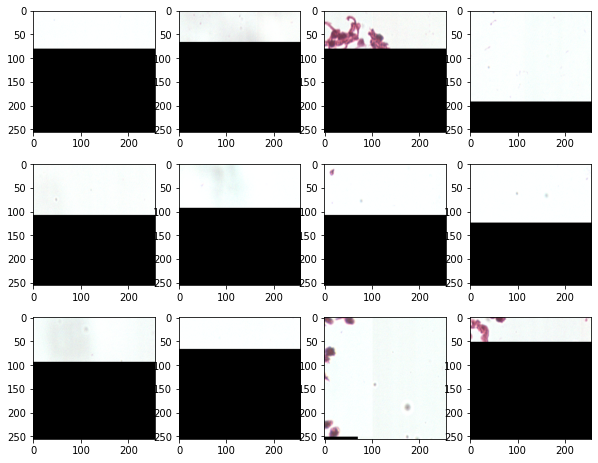

In [ ]:
show_sample(2, scaledData)

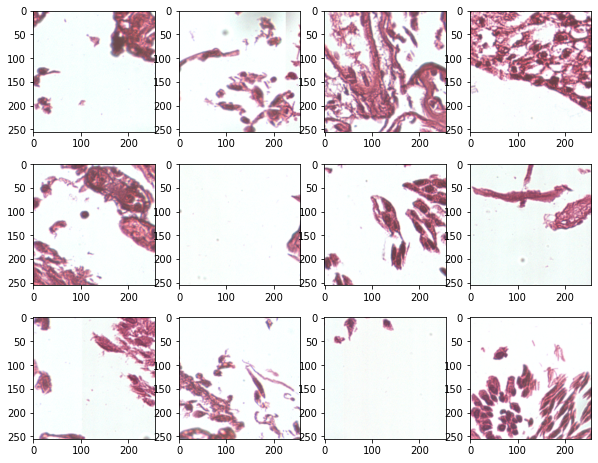

In [ ]:
show_sample(3, scaledData)

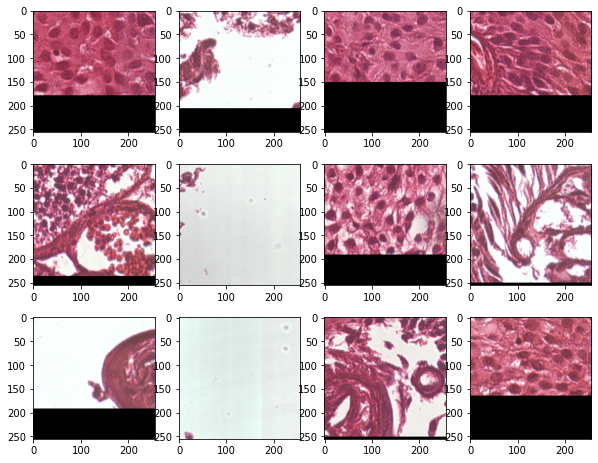

In [ ]:
show_sample(4, scaledData)

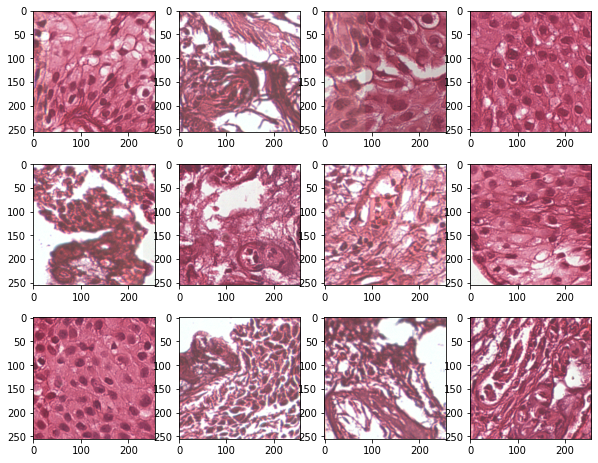

In [ ]:
show_sample(5, scaledData)

#Sample Tiles For PCA & T-SNE

In [ ]:
directory = "newtiles/"
images = []
imagesDf = pd.DataFrame([])
for filename in tqdm(os.listdir(directory)):
    if (filename.endswith('tif') or filename.endswith('jpeg') or filename.endswith('jpg') or filename.endswith('png')):
        img = tiffile.imread(directory+filename)
        img = img.flatten()
        images.append(img)

100%|██████████| 18190/18190 [00:38<00:00, 476.93it/s]


In [ ]:
images = np.array(images)

In [ ]:
images.shape

(18190, 196608)

In [ ]:
SAMPLE_SIZE = 3000
samples = images[np.random.randint(images.shape[0], size=SAMPLE_SIZE), :]

In [ ]:
samples.shape

(3000, 196608)

In [ ]:
del images

In [ ]:
import gc
gc.collect()

2609

#PCA

In [ ]:
from sklearn.decomposition import PCA
# from sklearn.decomposition import IncrementalPCA
# from sklearn.decomposition import TruncatedSVD
# from scipy.sparse import csr_matrix
# pcamodel = TruncatedSVD(n_components = 0.97, algorithm='arpack')
pcamodel = PCA(n_components=0.97)
# pcamodel = IncrementalPCA(batch_size=50, n_components=50)

In [ ]:
res = pcamodel.fit_transform(samples)

In [ ]:
import pickle as pk
pk.dump(pcamodel, open("pcamodel.pkl","wb"))


In [ ]:
from numpy import save
save("samples.npy", samples)
save("res.npy", res)

In [ ]:
res.shape

(8000, 1665)

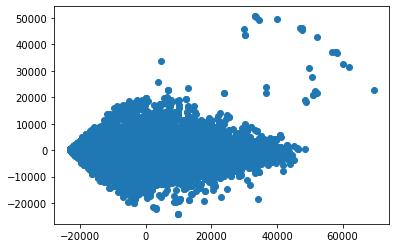

In [ ]:
plt.scatter(res[:, 0], res[:, 1])

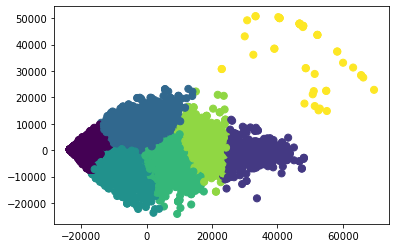

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters= 7)
labels = kmeans.fit_predict(res)
plt.scatter(res[:, 0], res[:, 1], c=labels, s=50, cmap='viridis', )

In [ ]:
import cv2
def show_sample(label):
    t = 0
    for i in range(len(samples)):
        if t > 5:
            break
        if labels[i] == label:
            t += 1
            imggg= samples[i].reshape(256,256,3)
            plt.imshow(imggg)
            plt.show()
        

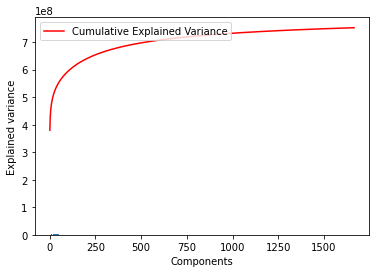

In [ ]:
plt.bar(range(1,len(pcamodel.explained_variance_ )+1),pcamodel.explained_variance_ )
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pcamodel.explained_variance_ )+1),
         np.cumsum(pcamodel.explained_variance_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')

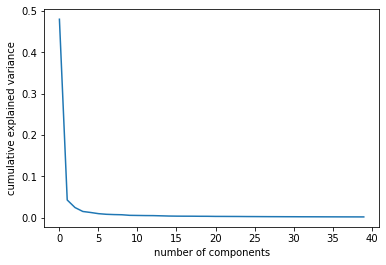

In [ ]:
plt.plot(pcamodel.explained_variance_ratio_[0:40])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

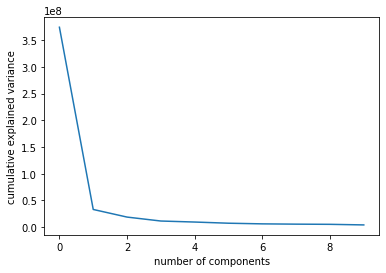

In [ ]:
plt.plot(pcamodel.explained_variance_[0:10])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#T-SNE

In [ ]:
std = samples.std(0)
std.shape

(196608,)

In [ ]:
mean = samples.mean(0)
mean.shape

(196608,)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(copy=False) 
scaler.scale_ = std
scaler.mean_ = mean
normalized_data = scaler.transform(samples)

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=50, learning_rate='auto', method='exact', perplexity=30 ,
                  init='random', verbose=1).fit_transform(normalized_data)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 14.675580
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.633921
[t-SNE] KL divergence after 700 iterations: 5.675803


In [39]:
np.save("/content/drive/MyDrive/zistagene/tsne-embed2.npy", X_embedded)

In [ ]:
X_embedded = np.load("/content/drive/MyDrive/zistagene/tsne-embed.npy")

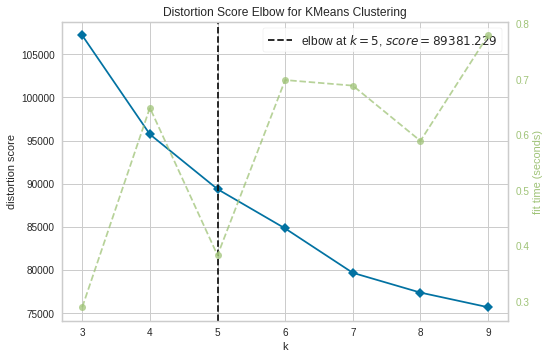

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(3,10)
)
visualizer.fit(X_embedded)       
visualizer.show()    


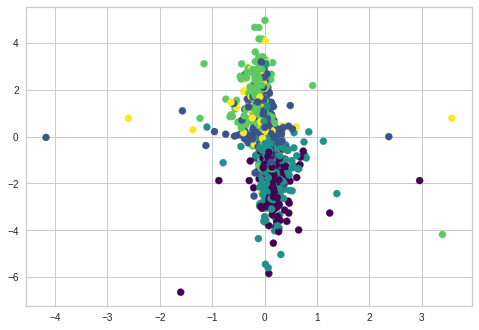

In [40]:
kmeans = KMeans(n_clusters = 5)
labels = kmeans.fit_predict(X_embedded)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, s=50, cmap='viridis', )

In [41]:
from sklearn.metrics import silhouette_score

silhouette_score(X_embedded, labels)

0.10605424

In [ ]:
from random import sample
def show_sample(label, data):
    samples = []
    for i in range(len(data)):
        if labels[i] == label:
            samples.append(data[i].reshape(256,256,3))
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))
    i = 0
    for s in sample(samples, min(12,len(samples))):
        axes[i//4,i%4].imshow(s)
        i+=1

In [ ]:
for i in range(5):
    print(f"samples with label: {i}")
    show_sample(i, samples)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.